In [57]:
# Imports 
import numpy as np
import librosa
from matplotlib import pyplot as plt

# Onset Strength Envelope

Calculating a perceptually weighted onset strength envelope.
- Audio resampled to 8 kHz
- Calculate STFT 32ms window, 4ms hop size 
- Mapped to 40 band Mel spectrogram
- Mel converted to dB
- First order difference along time calculated for each band
- Half wave rectification (Negative value set to zero)
- Sum across bands
- High pass filter 0.4 Hz (make it locally zero mean)
- Convolved with Gaussian envelope 20ms wide - I havent done this
- Normalise onset envelope by dividing by musical excerpt standard deviation

This should result in 1D onset envelope strength as a function of time that responds to a proportional increase in energy summed across approximately auditory frequency bands.

In [59]:
from scipy.signal import butter, filtfilt, lfilter

# butterworth highpass filter
def high_pass_filter(y, sr, cutoff=0.4, order=1):
    """Apply a high-pass filter to the signal."""
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = filtfilt(b, a, y, axis=0)
    return y_filtered

def mel_db(sr, stft, n_fft, hop_length, n_mels=40):
    abs_stft = abs(stft)
    
    # Create a Mel spectrogram with 40 Mel bands
    mel = librosa.feature.melspectrogram(S=abs_stft**2, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # Convert power spectrogram (amplitude squared) to dB
    mel_db = librosa.power_to_db(mel)
    
    return mel_db
    
# Onset strength envelope
def onset_strength_envelope(y, sr, window_sec=0.032, hop_sec=0.004, show=False):    
    # Calculate the STFT with a 32ms window and 4ms hop size
    n_fft = int(window_sec * sr)  # Window seconds to samples
    hop_length = int(hop_sec * sr)  # Hop seconds to samples
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # apply mel scale with 40 bands
    mel = mel_db(sr, stft, n_fft, hop_length)
    
    # apply first order difference
    mel_dif = np.diff(mel, axis=1)
    
    # half wave rectify
    mel_half_rec = np.maximum(0, mel_dif)
    
    # sum across bands
    onset_strength = np.sum(mel_half_rec , axis=0)
    
    # librosa remove DC like this - How do they do this in lab solution?
    onset_strength = lfilter([1.0, -1.0], [1.0, -0.99], onset_strength, axis=-1)
    
    # normalise to standard deviation (add small number to avoid div by 0) 
    # find significant difference from mean   
    onset_strength_norm  = onset_strength / np.std(onset_strength) + 1e-10 
    
    if(show): plot_onset_envelope_strength(y, onset_strength_norm, hop_sec)
        
    return onset_strength_norm

def plot_onset_envelope_strength(y, onset_strength, hop_sec):
    hop_length = int(hop_sec * sr)
    
    # normalise range 0 - 1
    onset_strength = onset_strength / np.max(onset_strength)
    
    # Time vector for plotting
    times = librosa.frames_to_time(np.arange(len(onset_strength)), sr=sr, hop_length=hop_length)
    
    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, (len(y) / sr), num=len(y)), y, alpha=0.6)  # Plot waveform
    plt.plot(times, onset_strength)
    plt.title('Onset Strength Envelope')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Normalized Onset Strength')
    plt.xlim([0, 10])
    plt.ylim([-0.1, 1.1])
    plt.show()

# hop_sec=0.004
# ose = onset_strength_envelope(y, sr, hop_sec=hop_sec)




# Global Tempo Estimate

Dynamic programming method dependant on tempo estimate.
- Use autocorrelation on onset strength envelope
- Apply perceptual weighting Gaussian window to raw autocorrelation
    - Gives TPS
    - Using T0 = 0.5 secs omegaT = 1.4 octaves
- Pick largest peak from TPS for tempo estimate

Extension:
Resample TPS to a half and a third, then adding the result to the original signal and picking the largest peak for tempo estimate.
- uses different values for T0 and omegaT

faster_tempo_level: 529.8788029595704, slower_tempo_level 317.52858731221636
faster_tempo weigth: 0.6252940545982538, slower_tempo weight 0.3747059454017462
weight ratio: 0.25058810919650765


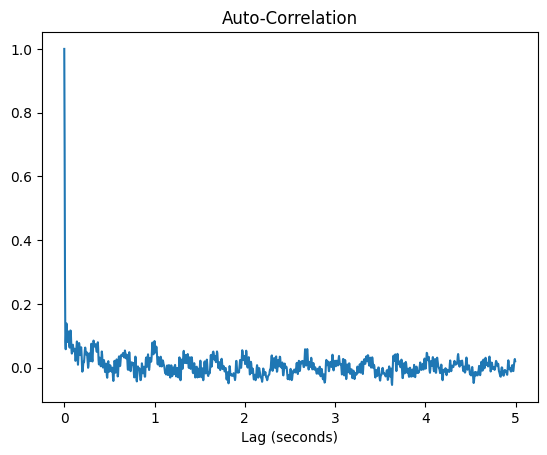

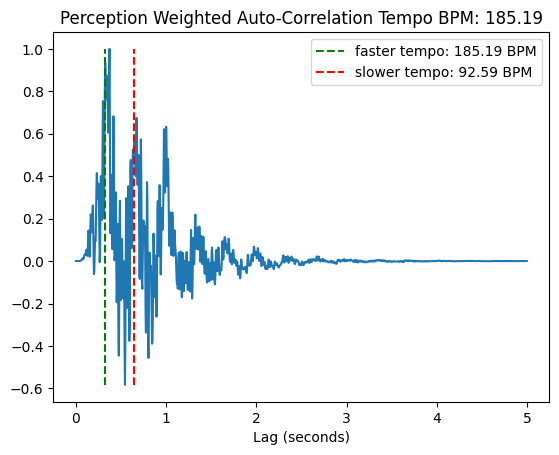

In [60]:

def plot_auto_c(auto_c, tps, faster_tempo, slower_tempo, selected_tempo, sr, hop_length):
    # calculate bpm for plot
    faster_tempo_bpm = round(60 * sr / (faster_tempo * hop_length), 2)
    slower_tempo_bpm = round(60 * sr / (slower_tempo * hop_length), 2)
    selected_tempo_bpm = round(60 * sr / (selected_tempo * hop_length), 2)
    
    auto_c = auto_c / np.max(auto_c)
    tps = tps / np.max(tps)
    
    times = np.arange(len(auto_c)) * (hop_length / sr)

    plt.plot(times, auto_c)
    plt.title('Auto-Correlation')
    plt.xlabel('Lag (seconds)')
    plt.show()

    plt.plot(times, tps)
    plt.vlines(faster_tempo * (hop_length / sr), ymin=min(tps), ymax=max(tps), color='g', linestyle='--', label='faster tempo: {} BPM'.format(faster_tempo_bpm))
    plt.vlines(slower_tempo * (hop_length / sr), ymin=min(tps), ymax=max(tps), color='r', linestyle='--', label='slower tempo: {} BPM'.format(slower_tempo_bpm))
    plt.legend()
    plt.title('Perception Weighted Auto-Correlation Tempo BPM: {}'.format(selected_tempo_bpm))
    plt.xlabel('Lag (seconds)')
    plt.show()
    
# Apply perceptual weighting based on tempo tapping data
def perceptual_weighting(t, t0=0.5, sigma_t=0.9): # t0 (bpm) and sigma_t (octaves) values from ellis 2007  
    # avoid div by zero error 
    epsilon = 1e-10
    t = np.maximum(t, epsilon)
    
    log_2_t_over_t0 = np.log2(t / t0)
    
    W_t = np.exp(-0.5 * (log_2_t_over_t0 / sigma_t) ** 2)
    
    return W_t

def tempo_multiples(tps):
    # only search 1/3 of the tps this should be plenty with 5 second tps
    tps_range = round(len(tps) / 3)
    
    tps_2 = np.zeros(tps_range)
    tps_3 = np.zeros(tps_range)

    for t in range(tps_range):
        # equation (7) and (8) - ellis 2007
        tps_2[t] = tps[t] + (0.5 * tps[2 * t]) + (0.25 * tps[(2 * t) - 1]) + (0.25 * tps[(2 * t) + 1])
        tps_3[t] = tps[t] + (0.33 * tps[3 * t]) + (0.33 * tps[(3 * t) - 1]) +(0.33 * tps[(3 * t) + 1])            
        
    duple = np.max(tps_2)
    triple = np.max(tps_3)
     
    # Whichever sequence contains the larger value determines whether the tempo is considered 
    # duple or triple, respectively, and the location of the largest value is treated as the 
    # faster target tempo, with one-half or one-third of that tempo, respectively, as the adjacent 
    # metrical level.   
    if duple > triple:
        faster_tempo_frame = np.argmax(tps_2)
        slower_tempo_frame = np.argmax(tps_2) * 2
        return faster_tempo_frame, slower_tempo_frame
    else: 
        faster_tempo_frame = np.argmax(tps_3)
        slower_tempo_frame = np.argmax(tps_3) * 3
        return faster_tempo_frame, slower_tempo_frame
  
def estimate_tempo(odf, sr, hop_sec=0.004, max_lag_s=5, weight_threshold_ratio=0.15, show=False):
    hop_length = int(hop_sec * sr)

    # only correlate reasonable tempo range 
    max_size = max_lag_s * sr / hop_length

    # auto correlate onset strength
    auto_c = librosa.autocorrelate(odf, max_size=max_size)

    # weighting function needs lag in seconds
    lags_seconds = np.arange(len(auto_c)) * (hop_length / sr)

    # apply perceptual weightinig get tempo period strengths
    tps = perceptual_weighting(lags_seconds) * auto_c
    
    # # calculate secondary bpm
    # # two further functions are calculated by resampling T P S to one-half and one-third, 
    # # respectively, of its original length, adding this to the original T P S, 
    # # then choosing the largest peak across both these sequences - ellis 2007
    faster_tempo_frame, slower_tempo_frame = tempo_multiples(tps)
    
    faster_tempo_peak = tps[faster_tempo_frame]
    slower_tempo_peak = tps[slower_tempo_frame]
    
    # Relative weights of the two levels are again taken from the relative peak heights 
    # at the two period estimates in the original T P S. This approach finds the tempo that maximizes
    # the sum of the T P S values at both metrical levels
    faster_tempo_weight = faster_tempo_peak / (faster_tempo_peak + slower_tempo_peak)
    slower_tempo_weight = slower_tempo_peak / (faster_tempo_peak + slower_tempo_peak)
               
    # start testing without - risk of over fitting to data set
    # weight difference decision rule - not explicitly mentioned in the paper - this is my idea 
    
    # weight difference threshold
    if (slower_tempo_weight > faster_tempo_weight): selected_tempo = slower_tempo_frame
    # test with decision rule - add in comparison to original tps peak 
    #else if abs(faster_tempo_weight - slower_tempo_weight) > weight_threshold_ratio: selected_tempo = slower_tempo_frame
    else: selected_tempo = faster_tempo_frame
        
    # plot results
    if(show): 
        print("faster_tempo_level: {}, slower_tempo_level {}".format(faster_tempo_peak, slower_tempo_peak))
        print("faster_tempo weigth: {}, slower_tempo weight {}".format(faster_tempo_weight, slower_tempo_weight))
        print('weight ratio: {}'.format(abs(faster_tempo_weight - slower_tempo_weight)))
        plot_auto_c(auto_c, tps, faster_tempo_frame, slower_tempo_frame, selected_tempo, sr, hop_length)

    return selected_tempo

# tempo_estimate = estimate_tempo(ose, sr, hop_sec, show=True)

# Beat Tracking
- Using dynamic programming to find each beat.
- Follow source code on Ellis 2007 paper.

In [61]:
def plot_dynamic_programming(c_score, backlink, ose, beats):
    # Plot the cumulative score and onset strength envelope
    plt.figure(figsize=(14, 6))
    plt.plot(ose, label='Onset Strength Envelope', color='blue', alpha=0.5)
    plt.plot(c_score, label='Cumulative Score', color='orange', alpha=0.8)

    # Add arrows for backlinks
    for i in range(1, len(c_score)):
        if backlink[i] != -1:
            plt.annotate('', xy=(i, c_score[i]), xytext=(backlink[i], c_score[backlink[i]]),
                        arrowprops=dict(arrowstyle="<-", color='gray', alpha=0.5))

    # Highlight the beats
    plt.scatter(beats, c_score[beats], color='red', zorder=5, label='Beats')

    plt.title('Dynamic Programming Beat Tracking Visualization')
    plt.xlabel('Time (frames)')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# ported from ellis 2007 matlab code
def beat_track(ose, tempo_estimate, sr, alpha=680, hop_sec=0.004, show=False):
    # initialize backlink and cumulative score arrays
    backlink = -np.ones(len(ose), dtype=int)
    c_score = ose.copy()
    
    # define search range for previous beat based on the period
    prev_range = np.arange(-2*tempo_estimate, -round(tempo_estimate/2), dtype=int)
    
    # calculate transition cost using a log-gaussian window over the search range
    cost = -alpha * np.abs(np.log(prev_range / -tempo_estimate) ** 2)

    # set up the dynamic programming loop bounds
    loop_start = max(-prev_range[0], 0)
    loop_end = len(ose)
    
    # use the loop to fill in backlink and cumlative score
    for i in range(loop_start, loop_end):
        timerange = i + prev_range
        # ensure timerange indices are within bounds
        valid_timerange = timerange[(timerange >= 0) & (timerange < len(ose))]
        if len(valid_timerange) == 0:
            continue  # skip if no valid timerange
        
        # calculate score candidates and find the best predecessor beat
        score_candiadates = cost[:len(valid_timerange)] + c_score[valid_timerange]
        max_score_index = np.argmax(score_candiadates)
        max_score = score_candiadates[max_score_index]
        
        # update cumulative score and backlink
        c_score[i] = max_score + ose[i]
        backlink[i] = valid_timerange[max_score_index]
    
    # start backtrace from the highest cumulative score
    beats = [np.argmax(c_score)]
    
    # backtrace to find all predecessors
    while backlink[beats[0]] > 0:
        beats.insert(0, backlink[beats[0]])
    
    hop_length = int(hop_sec * sr)
    times = librosa.frames_to_time(beats, sr=sr, hop_length=hop_length)
    
    if(show): plot_dynamic_programming(c_score, backlink, ose, beats) # this can take more than 1 minute to render
    
    return times

beats_estimates = beat_track(ose, tempo_estimate, sr, hop_sec=hop_sec)

# Evaluation

In [62]:
from mir_eval import beat as beats_eval

def evaluation(beats_ref, beats_est, trim=False):
    if trim: 
        beats_ref = beats_eval.trim_beats(beats_ref)
        beats_est = beats_eval.trim_beats(beats_est)
    
    f_measure = beats_eval.f_measure(beats_ref, beats_est)
    cemgil = beats_eval.cemgil(beats_ref, beats_est)
    goto = beats_eval.goto(beats_ref, beats_est)
    # p_score = beats_eval.p_score(beats_ref, beats_est) broken: numpy depricated int error in mir_eval lib
    continuity = beats_eval.continuity(beats_ref, beats_est)
    information_gain = beats_eval.information_gain(beats_ref, beats_est)
    
    return {
        "f_measure": f_measure, 
        "cemgil": cemgil,
        "goto": goto,
        #"p_score": p_score, broken - see above comment
        "continuity": continuity, 
        "information_gain": information_gain 
    }

# Testing on full dataset

In [107]:
import os

class Song:
    name = None
    audio_file = None
    annotations_file = None
    genre = None
    meter = None
    beats_reference = None # change to beat annotations ?
    beats_estimates = None
    evaluation = None
    tempo = None

def get_beat_annotations(beats_path):
    beats_file = open(beats_path, 'r')
    beats_lines = beats_file.readlines()
    beats_reference = np.array([])

    for line in beats_lines:
        beat = line[:10]
        beats_reference = np.append(beats_reference, float(beat))
       
    return beats_reference 
 
def read_data(audio_dir, annotation_dir, recompute = 0):
    """Creates an array of objects, one for each file, containing path names
    for audio and annotation files, dance style, metre and tempo.
    Each audio file is in a folder defining the dance style
    (e.g. samba, cha cha, waltz). A parallel set of annotation files contain
    two integers for each piece giving the beginning and end of the first bar,
    in milliseconds.
    """
    dump_file = 'data/ballroom_data_dump.npy'
    if not recompute and os.path.exists(dump_file):
        return np.load(dump_file, allow_pickle=True)
    
    songs: Song = []
    for entry in os.scandir(audio_dir):
        if os.path.isdir(entry) == False: continue # ignore hidden files
     
        for file in os.scandir(entry.path):
            song = Song()
            song.audio_file = file.path
            song.annotations_file = annotation_dir + '/' + file.name[:-4] + ".beats"
            song.name = file.name[:-4]
            song.genre = entry.name
            if song.genre[-5:] == 'Waltz':
                song.metre = 3
            else:
                song.metre = 4
            song.beats_reference = get_beat_annotations(song.annotations_file)
            # obj.barTimes = np.divide(np.fromfile(obj.baseName + '.beats', sep = ' '),
            #                      1000)
            song.tempo = 60 / (song.beats_reference[1] - song.beats_reference[0]) # this is not very accurate
            songs.append(song)
            
    np.save(dump_file, songs)
    return songs

# The whole system should be called via this function
def beatTrack(audio_file, name, genre, annotations=[], xlim=[10, 20], show=False):
    hop_sec=0.004
    resample_rate = 8000

    # load audio
    y, sr = librosa.load(audio_file, sr=resample_rate)
    ose = onset_strength_envelope(y, sr, hop_sec=hop_sec, show=show)
    tempo_estimate = estimate_tempo(ose, sr, hop_sec=hop_sec, show=show)
    beats_estimates = beat_track(ose, tempo_estimate, sr, hop_sec=hop_sec, show=False) # plot here can take up to a miniute
    
    if(show and len(annotations) > 0): 
        # plot estimated vs reference 
        plt.figure(figsize=(10, 4))
        plt.title('Beats for {} - {}'.format(name, genre)) # add bpm
        plt.plot(np.linspace(0, (len(y) / sr), num=len(y)), y, alpha=0.6)  # plot waveform
        plt.vlines(beats_estimates, ymin=0, ymax=max(y), color='r', linestyle='--', label='estimates')  # plot beats
        plt.vlines(annotations, ymin=min(y), ymax=0, color='g', linestyle='--', label='annotations')  # plot annotations
        plt.legend()
        plt.xlim(xlim)
    
    return beats_estimates
 
def test_dataset(songs_data, genres=[], recompute=False):
    dump_file = 'data/analysis_dump.npy'
    if not recompute and os.path.exists(dump_file):
        return np.load(dump_file, allow_pickle=True)
    
    # use for no re-compute to work
    # dtype = [('genre', 'U20'), ('f_measure_mean', 'f4')]
    # f_measure_means = np.array([], dtype=dtype)
    
    f_measure_means = {}
    global_f_measure_sum = 0.0
    global_f_measure_count = 0
    
    for genre in genres: 
        # create mean variables
        genre_f_measure_sum = 0.0
        genre_songs_count = 0
        
        for song in songs_data:
            if song.genre != genre: continue # only test selected genres
                        
            beats = beatTrack(song.audio_file, name=song.name, genre=song.genre, annotations=song.beats_reference, show=False)
            evaluation_results = evaluation(song.beats_reference, beats)
            
            # f_measure for genre
            genre_songs_count += 1
            genre_f_measure_sum += evaluation_results['f_measure']
            
            # f_measure for all songs
            global_f_measure_count += 1
            global_f_measure_sum += evaluation_results['f_measure']
        
        # new_row = np.array([(genre, genre_f_measure_sum / genre_songs_count)], dtype=dtype)
        # f_measure_means = np.concatenate((f_measure_means, new_row), axis=0)
        
        # calculate mean for genre
        f_measure_means[genre] = genre_f_measure_sum / genre_songs_count
    
    # global_mean = global_f_measure_sum / global_f_measure_count
    # f_measure_means = np.concatenate((f_measure_means, np.array([('global', global_mean)], dtype=dtype)), axis=0)
    
    f_measure_means["Global"] = global_f_measure_sum / global_f_measure_count
    
    np.save(dump_file, f_measure_means) 
    return f_measure_means 

def plot_results(f_measure_means):
    names = list(f_measure_means.keys())
    values = list(f_measure_means.values())
        
    plt.figure(figsize=(10, 6))
    bars = plt.bar(names, values)

    plt.xlabel('Genres')
    plt.ylabel('F-Measure')
    plt.title('F-Measures')
    plt.xticks(rotation=45) 
    
    # add values to bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')
    
    plt.show()

# evaluate system
songs_data = read_data('data/BallroomData','data/BallroomAnnotations')
all_genres = ["ChaChaCha", # get BallroomData dir names instead
              "Jive", 
              "Quickstep", 
              "Rumba-American",  
              "Rumba-International", 
              "Rumba-Misc", 
              "Samba", 
              "Tango",
              "VienneseWaltz",
              "Waltz"]

f_measure_means = test_dataset(songs_data, genres=all_genres, recompute=True) # runtime ~4 mins
plot_results(f_measure_means)

# evaluate different free variables

# find best performer and worst performer ?